<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">


# Web Scraping for Indeed.com and Predicting Salaries

### Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal wants you to

   - determine the industry factors that are most important in predicting the salary amounts for these data.

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries.

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer this question.

---

### Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to address the question above.

### Factors that impact salary

To predict salary the most appropriate approach would be a regression model.
Here instead we just want to estimate which factors (like location, job title, job level, industry sector) lead to high or low salary and work with a classification model. To do so, split the salary into two groups of high and low salary, for example by choosing the median salary as a threshold (in principle you could choose any single or multiple splitting points).

Use all the skills you have learned so far to build a predictive model.
Whatever you decide to use, the most important thing is to justify your choices and interpret your results. *Communication of your process is key.* Note that most listings **DO NOT** come with salary information. You'll need to be able to extrapolate or predict the expected salaries for these listings.

### Scraping job listings from Indeed.com

We will be scraping job listings from Indeed.com using BeautifulSoup. Luckily, Indeed.com is a simple text page where we can easily find relevant entries.

First, look at the source of an Indeed.com page: (http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10").

Notice, each job listing is underneath a `div` tag with a class name of `result`. We can use BeautifulSoup to extract those. 

#### Setup a request (using `requests`) to the URL below. Use BeautifulSoup to parse the page and extract all results (HINT: Look for div tags with class name result)

The URL here has many query parameters:

- `q` for the job search
- This is followed by "+20,000" to return results with salaries (or expected salaries >$20,000)
- `l` for a location 
- `start` for what result number to start on

In [1]:
URL = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

In [2]:
import numpy as np
import pandas as pd
from pprint import pprint

In [3]:
import requests
import bs4
from bs4 import BeautifulSoup
from tqdm import tqdm

In [4]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

results = soup.find_all('div', class_='result')

In [5]:
print(results[0].prettify())

<div class="jobsearch-SerpJobCard unifiedRow row result" data-jk="7e41b7c3364fc870" data-tn-component="organicJob" id="p_7e41b7c3364fc870">
 <h2 class="title">
  <a class="jobtitle turnstileLink" data-tn-element="jobTitle" href="/rc/clk?jk=7e41b7c3364fc870&amp;fccid=01fd1f2f239c15f4&amp;vjs=3" id="jl_7e41b7c3364fc870" onclick="setRefineByCookie(['salest']); return rclk(this,jobmap[0],true,0);" onmousedown="return rclk(this,jobmap[0],0);" rel="noopener nofollow" target="_blank" title="Data Scientist">
   <b>
    Data
   </b>
   <b>
    Scientist
   </b>
  </a>
 </h2>
 <div class="sjcl">
  <div>
   <span class="company">
    <a class="turnstileLink" data-tn-element="companyName" href="/cmp/Unite-US" onmousedown="this.href = appendParamsOnce(this.href, 'from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=7e41b7c3364fc870&amp;jcid=b29cc11be8619d61')" rel="noopener" target="_blank">
     Unite Us
    </a>
   </span>
   <span class="ratingsDisplay">
    <a aria-label="Company rating 5.0

Let's look at one result more closely. A single `result` looks like

```
<div class=" row result" data-jk="2480d203f7e97210" data-tn-component="organicJob" id="p_2480d203f7e97210" itemscope="" itemtype="http://schema.org/JobPosting">
<h2 class="jobtitle" id="jl_2480d203f7e97210">
<a class="turnstileLink" data-tn-element="jobTitle" onmousedown="return rclk(this,jobmap[0],1);" rel="nofollow" target="_blank" title="AVP/Quantitative Analyst">AVP/Quantitative Analyst</a>
</h2>
<span class="company" itemprop="hiringOrganization" itemtype="http://schema.org/Organization">
<span itemprop="name">
<a href="/cmp/Alliancebernstein?from=SERP&amp;campaignid=serp-linkcompanyname&amp;fromjk=2480d203f7e97210&amp;jcid=b374f2a780e04789" target="_blank">
    AllianceBernstein</a></span>
</span>
<tr>
<td class="snip">
<nobr>$117,500 - $127,500 a year</nobr>
<div>
<span class="summary" itemprop="description">
C onduct quantitative and statistical research as well as portfolio management for various investment portfolios. Collaborate with Quantitative Analysts and</span>
</div>
</div>
</td>
</tr>
</table>
</div>
```

While this has some more verbose elements removed, we can see that there is some structure to the above:
- The salary is in a `span` with `class='salaryText'`.
- The title of a job is in a link with class set to `jobtitle` and a `data-tn-element='jobTitle'`.  
- The location is set in a `span` with `class='location'`. 
- The company is set in a `span` with `class='company'`. 
- Decide which other components could be relevant, for example the region or the summary of the job advert.

In [6]:
jobs = {
    'salary': [],
    'job_title': [],
    'location': [],
    'company': [],
    'company_rating': [],
    'description': []
}

for job in results:
    try:
        jobs['salary'].append(job.find('span', class_='salaryText').text)
    except:
        jobs['salary'].append(np.nan)
        
    try:
        # job.find('h2', class_='title').find('a')['title']
        jobs['job_title'].append(job.find('a', attrs={'data-tn-element': 'jobTitle'})['title'])
    except:
        jobs['job_title'].append(np.nan)
        
    try:
        jobs['location'].append(job.find('span', class_='location').text.strip())  
    except:
        jobs['location'].append(np.nan)
        
    try:
        company_name = job.find('a', attrs={'data-tn-element':'companyName'})
        if company_name:
            jobs['company'].append(company_name.text.strip())
        else:
            jobs['company'].append(job.find('span', class_='company').text.strip())
    except:
        jobs['company'].append(np.nan)
        
    try:
        jobs['company_rating'].append(job.find('span', class_='ratingsContent').text.strip())
    except:
        jobs['company_rating'].append(np.nan)
        
    try:
        lists = job.find('div', class_='summary').find_all('li')   
        jobs['description'].append((' ').join([lst.text for lst in lists]))
    except:
        jobs['description'].append(np.nan)
        

In [7]:
pprint(jobs)

{'company': ['Unite Us',
             'Sightly Enterprises',
             'Warner Music Group',
             'IBM',
             'Naval Nuclear Laboratory',
             'RISIRISA',
             'QuaEra',
             'MassMutual',
             'New York University',
             'BNY Mellon',
             'World Education Services',
             'Altice',
             'A Place for Mom',
             'BlackRock',
             'Earnest Research'],
 'company_rating': ['5.0',
                    nan,
                    '4.1',
                    '3.9',
                    '2.8',
                    nan,
                    nan,
                    '3.7',
                    '4.2',
                    '3.5',
                    '3.6',
                    '3.4',
                    '2.9',
                    '3.8',
                    nan],
 'description': ['Experience with healthcare data and analytics is preferred. '
                 'Experience working with health data, or in a healthca

In [8]:
pd.DataFrame(jobs).head()

,salary,job_title,location,company,company_rating,description
0,NaN,Data Scientist,New York State,Unite Us,5.0,Experience with healthcare data and analytics ...
1,NaN,DATA SCIENTIST,"New York, NY",Sightly Enterprises,NaN,Gathering and analyzing unique ad placement an...
2,NaN,"Econometric Data Scientist, International","New York, NY",Warner Music Group,4.1,Interact with data engineering teams to identi...
3,NaN,Research Scientist - Artificial Intelligence,"Yorktown Heights, NY 10598",IBM,3.9,"Computing and data services, including emergin..."
4,NaN,Data Scientist,"Niskayuna, NY 12309",Naval Nuclear Laboratory,2.8,"Processing, refining, and verifying the integr..."


### Write 4 functions to extract each item: location, company, job, and salary.

Example: 
```python
def extract_location_from_result(result):
    return result.find ...
```


- **Make sure these functions are robust and can handle cases where the data/field may not be available.**
    - Remember to check if a field is empty or `None` for attempting to call methods on it.
    - Remember to use `try/except` if you anticipate errors.
- **Test** the functions on the results above and simple examples.

In [9]:
def not_null(content):
    """return content or raise exception if no content is given"""
    if content not in ('', None):
        return content
    else:
        raise Exception('No content found!')

In [10]:
def extract_location_from_result(result):
    """return location of the company"""
    try:
        data = result.find('span', class_='location').text.strip()
        return not_null(data)
    except:
        return np.nan

In [11]:
def extract_company_from_result(result):
    """return company name"""
    try:
        company_name = result.find('a', attrs={'data-tn-element':'companyName'})
        if company_name:
            return not_null(company_name.text.strip())
        else:
            data = result.find('span', class_='company').text.strip()
            return not_null(data)
    except:
        return np.nan

In [12]:
def extract_job_from_result(result):
    """return job title"""
    try:
        return not_null(result.find('a', attrs={'data-tn-element': 'jobTitle'})['title'])
    except:
        return np.nan
        

In [13]:
def extract_salary_from_result(result):
    """return salary"""
    try:
        return not_null(result.find('span', class_='salaryText').text.strip())
    except:
        return np.nan

In [14]:
def extract_rating_from_result(result): 
    """return company rating"""
    try:
        return not_null(result.find('span', class_='ratingsContent').text.strip())
    except:
        return np.nan

In [15]:
def extract_summary_from_result(result):
    """return job description"""
    try:
        lists = result.find('div', class_='summary').find_all('li')   
        return not_null((' ').join([lst.text for lst in lists]))
    except:
        return np.nan

In [16]:
r = requests.get(URL)
soup = BeautifulSoup(r.text, 'html.parser')

results = soup.find_all('div', class_='result')

In [17]:
salary = []
job_title = [] 
location = []
company = []
summary = []
rating = []

for job in results:
    salary.append(extract_salary_from_result(job))
    job_title.append(extract_job_from_result(job))
    location.append(extract_location_from_result(job))
    company.append(extract_company_from_result(job))
    rating.append(extract_rating_from_result(job))
    summary.append(extract_summary_from_result(job))
    

job_market = pd.DataFrame({'job_title': job_title,
                           'location': location,
                           'company': company,
                           'salary': salary,
                           'summary': summary,
                           'rating': rating})

job_market.head(10)

,job_title,location,company,salary,summary,rating
0,Data Scientist,New York State,Unite Us,NaN,Experience with healthcare data and analytics ...,5.0
1,DATA SCIENTIST,"New York, NY",Sightly Enterprises,NaN,Gathering and analyzing unique ad placement an...,NaN
2,"Econometric Data Scientist, International","New York, NY",Warner Music Group,NaN,Interact with data engineering teams to identi...,4.1
3,Research Scientist - Artificial Intelligence,"Yorktown Heights, NY 10598",IBM,NaN,"Computing and data services, including emergin...",3.9
4,Data Scientist,"Niskayuna, NY 12309",Naval Nuclear Laboratory,NaN,"Processing, refining, and verifying the integr...",2.8
5,Data Scientist,"New York, NY",RISIRISA,NaN,Experience with a range of data science techni...,NaN
6,Data Scientist,"New York, NY 10018 (Garment District area)",QuaEra,NaN,"Experience with R, Python, PySpark and data vi...",NaN
7,Data Scientist,"New York, NY",MassMutual,NaN,3+ years working with data and relevant comput...,3.7
8,Research Scientist-Center for Data Science,"New York, NY 10012 (Greenwich Village area)",New York University,NaN,Completion of Master's degree in disciplines a...,4.2
9,Data Scientist,"New York, NY 10286 (Tribeca area)",BNY Mellon,NaN,"As a data scientist, you will be embedded with...",3.5


Now, to scale up our scraping, we need to accumulate more results. We can do this by examining the URL above.

- "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10"

There are two query parameters here we can alter to collect more results, the `l=New+York` and the `start=10`. The first controls the location of the results (so we can try a different city). The second controls where in the results to start and gives 10 results (thus, we can keep incrementing by 10 to go further in the list).

In [18]:
# http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l=New+York&start=10%22

titles = ['data scientist', 
          'data analyst',
          'research scientist',
          'business intelligence',
          'database developer',
          'data engineer',
          'database administrator']

cities = ['New York',
          'Dallas',
          'Boston',
          'Houston',
          'San Francisco',
          'Seattle',
          'Austin',
          'Miami',
          'New Orleans',
          'Atlanta',
          'Jacksonville',
          'Chicago',
          'Philadelphia',
          'Las Vegas',
          'Los Angeles',
          'Phoenix']

titles_encoded = ('%2C+').join([t.replace(' ', '+') for t in set(titles)])

# Ascii Encoding Reference:
# space -> %20
# # -> %23
# $ -> %24
# % -> %25
# & -> %26
# , -> %2C

The indeed website analyses the user behaviour and blocks further server requests after a while by enabling captchas. In the first attempt several endeavors were taken to create a workaround for these captchas like rotating user agents in the html requests, changing proxy addresses and applying random delays. Unfortunately, the ip addresses from a free proxy server list can be detected by the website to make them useless. Further attempts have shown that these captchas occur after a specific number html requests from the same ip address. For this reason, the scraping function is implemented in a way to split the requests by setting the job locations and titles manually. After each request the ip address was changed with vpn software. 

In [19]:
import time, random

In [20]:
# https://www.scrapehero.com/how-to-fake-and-rotate-user-agents-using-python-3/

user_agent_list = [
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/13.1.1 Safari/605.1.15',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
    'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:77.0) Gecko/20100101 Firefox/77.0',
    'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36',
]

headers = {
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9", 
    "Accept-Encoding": "gzip, deflate, sdch", 
    "Accept-Language": "en-GB,en-US;q=0.9,en;q=0.8", 
    "Dnt": "1", # do not track (1... prefers not to be tracked)
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",
#     "Host": "indeed.com",
#     "Cache-Control": "max-age=0",
  }


In [21]:
# code is used from https://www.scrapehero.com/how-to-rotate-proxies-and-ip-addresses-using-python-3/
# xpath expressions:
# / -> selects from the root node (if occurring after a node then referring to children node)
# // -> selects nodes from the current node
# . -> selects current node

# from lxml.html import fromstring
# def get_proxies():
#     """return ip address and port from a proxy server"""
# #     url = 'https://free-proxy-list.net/'
#     url = 'https://www.us-proxy.org/'
#     response = requests.get(url)
#     # fromstring() returns document_fromstring or fragment_fromstring
#     parser = fromstring(response.text)
#     proxies = set()
#     for i in parser.xpath('//tbody/tr')[:20]:
#         if i.xpath('.//td[7][contains(text(),"yes")]'):  # <td class='hx'>yes</td>
#             #Grabbing IP and corresponding PORT
#             # i.xpath('.//td[1]')[0].text
#             proxy = ":".join([i.xpath('.//td[1]/text()')[0], i.xpath('.//td[2]/text()')[0]])
#             proxies.add(proxy)
#     return proxies

In [22]:
def scrape_indeed(cities, titles_encoded, headers=None, user_agent_list=None, delay=False):
    """
    This function scrapes the indeed platform and returns a data frame with relevant job features (title, location,
    company, salary, rating and description). 
    
    
    Parameters:
    
    cities (list): a list of city names
    titles_encoded (str): ascii encoded string with all job titles
    headers (dict): optional html request header
    user_agent_list (list): Optional container of user agents for 'User-Agent' attribute of the header html request.
                            It can only be applied if headers parameter is added. 
    delay (boolean): if true, then time delays are executed during the single server requests to decrease the chance 
                     of getting blocked
    
    
    Returns:
    
    df (pd.DataFrame): dataframe with following features: 
                                                           - job_title
                                                           - location
                                                           - company
                                                           - salary
                                                           - rating
                                                           - summary
    """
    salary = []
    job_title = [] 
    location = []
    company = []
    rating = []
    summary = []
    url_template = "http://www.indeed.com/jobs?q={job}+%2420%2C000&l={location}&start={page}"
    
    if type(cities) != list:
        raise Exception('cities parameter must be a list')
        return

#     from itertools import cycle
#     proxies = get_proxies()
#     proxy_pool = cycle(proxies)

    for c in tqdm(set(cities)):
        if user_agent_list and headers:
            user_agent = random.choice(user_agent_list)
            headers['User-Agent'] = user_agent
#         proxy = next(proxy_pool)
#         proxy_flag = False

#         while not proxy_flag:
#             try:
#                 response = requests.get('http://www.indeed.com', proxies={'http': proxy, 'https': proxy})
#                 print(f"Request {c}")
#                 print(response.json())
#                 proxy_flag = True
#             except:
#                 proxy = next(proxy_pool)
#                 print("Skipping. Connnection error")

        for page in tqdm(range(10, 800, 10), position=0):
            try:
                r = requests.get(url_template.format(job=titles_encoded,
                                                     location=c.replace(' ', '+'),
                                                     page=page),
                                 headers=headers)
#                                  proxies={"http": proxy, "https": proxy})
            except:
                raise Exception('check headers')

            soup = BeautifulSoup(r.text, 'html.parser')
            results = soup.find_all('div', class_='result')

            # when the last result is shown a message box appears which includes 
            # a paragraph with a class attribute called 'dupetext'
            duplicate_msg = soup.find('p', class_='dupetext')

            for job in results:
                salary.append(extract_salary_from_result(job))
                job_title.append(extract_job_from_result(job))
                location.append(extract_location_from_result(job))
                company.append(extract_company_from_result(job))
                rating.append(extract_rating_from_result(job))
                summary.append(extract_summary_from_result(job))

            if not results or duplicate_msg:  # nothing found or end result is reached
                if delay:
                    time.sleep(15 + random.random() * 10)  # 15-25 sec, prevent to submit captchas
                print(f'{c} with {page/10} pages.')
                break
            elif page % 80 == 0:
                if delay:
                    time.sleep(10 + random.random() * 5)  # 10-15 sec
            else:
#                 print(f'city: {c}, page: {page}')
                if delay:
                    time.sleep(1 + random.random() * 3)  # 1-4 sec
                
    df = pd.DataFrame({'job_title': job_title,
                       'location': location,
                       'company': company,
                       'salary': salary,
                       'rating': rating,
                       'summary': summary})
    return df

In [23]:
from pathlib import Path

In [24]:
def check_file_exists(filename, cities, titles_encoded, headers=None, user_agent_list=None, delay=False):
    """
    Applying the scrape_indeed function and additionally saving the data frame.
    
    Parameters:
    
    filename (str): file name without extension (.csv)
    cities (list): a list of city names
    titles_encoded (str): ascii encoded string with all job titles
    headers (dict): optional html request header
    user_agent_list (list): Optional container of user agents for 'User-Agent' attribute of the header html request.
                            It can only be applied if headers parameter is added. 
    delay (boolean): if true, then time delays are executed during the single server requests to decrease the chance 
                     of getting blocked
    
    Returns:
    
    df (pd.DataFrame): dataframe with following features: 
                                                           - job_title
                                                           - location
                                                           - company
                                                           - salary
                                                           - rating
                                                           - summary
    """
    file = Path(f"./datasets/{filename}.csv")
    if not file.exists():
        df = scrape_indeed(cities=cities, titles_encoded=titles_encoded, 
                           headers=headers, user_agent_list=user_agent_list, 
                           delay=delay)
        df.to_csv(f'./datasets/{filename}.csv', index=False)
        
        return df
    else:
        print('file already exists')

In [25]:
check_file_exists('df_0', cities=[cities[0]], titles_encoded=titles_encoded, headers=headers, user_agent_list=user_agent_list)
df_0 = pd.read_csv('./datasets/df_0.csv')
df_0.head()

file already exists


,job_title,location,company,salary,rating,summary
0,Data Analyst,"Syracuse, NY",Excelacom,NaN,3.2,Bachelor’s Degree or higher. Responds to data ...
1,Data Analyst/Assistant Research Scientist (par...,"New York, NY 10012 (Greenwich Village area)",New York University,$18 an hour,4.2,Cultivate deep familiarity with methodological...
2,Business Intelligence Analyst,"New York, NY 10176 (Murray Hill area)",CBS Interactive,NaN,3.5,"As a business intelligence analyst, you’ll lea..."
3,Business Data Analyst,"Melville, NY 11747",North American Partners in Anesthesia,NaN,2.9,1+ year of hands-on experience with MS SQL as ...
4,Data Scientist,"New York, NY",Northwestern Mutual,NaN,3.8,This team focuses on developing data science m...


In [26]:
df_0[df_0['salary'].notnull()].shape

(57, 6)

### Complete the following code to collect results from multiple cities and starting points. 
- Enter your city below to add it to the search.
- Remember to convert your salary to U.S. Dollars to match the other cities if the currency is different.

#### Use the functions you wrote above to parse out the 4 fields - location, title, company and salary. Create a dataframe from the results with those 4 columns.

In [27]:
len(cities)

16

In [28]:
check_file_exists('df_1', cities=[cities[1]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_1 = pd.read_csv('./datasets/df_1.csv')

file already exists


In [29]:
check_file_exists('df_2', cities=[cities[2]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_2 = pd.read_csv('./datasets/df_2.csv')

file already exists


In [30]:
check_file_exists('df_3', cities=[cities[3]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_3 = pd.read_csv('./datasets/df_3.csv')

file already exists


In [31]:
check_file_exists('df_4', cities=[cities[4]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_4 = pd.read_csv('./datasets/df_4.csv')

file already exists


In [32]:
check_file_exists('df_5', cities=[cities[5]], titles_encoded=titles_encoded)
df_5 = pd.read_csv('./datasets/df_5.csv')

file already exists


In [33]:
check_file_exists('df_6', cities=[cities[6]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_6 = pd.read_csv('./datasets/df_6.csv')

file already exists


In [34]:
check_file_exists('df_7', cities=[cities[7]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_7 = pd.read_csv('./datasets/df_7.csv')

file already exists


In [35]:
check_file_exists('df_8', cities=[cities[8]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_8 = pd.read_csv('./datasets/df_8.csv')

file already exists


In [36]:
check_file_exists('df_9', cities=[cities[9]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_9 = pd.read_csv('./datasets/df_9.csv')

file already exists


In [37]:
check_file_exists('df_10', cities=[cities[10]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_10 = pd.read_csv('./datasets/df_10.csv')

file already exists


In [38]:
check_file_exists('df_11', cities=[cities[11]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_11 = pd.read_csv('./datasets/df_11.csv')

file already exists


In [39]:
check_file_exists('df_12', cities=[cities[12]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_12 = pd.read_csv('./datasets/df_12.csv')

file already exists


In [40]:
check_file_exists('df_13', cities=[cities[13]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_13 = pd.read_csv('./datasets/df_13.csv')

file already exists


In [41]:
check_file_exists('df_14', cities=[cities[14]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_14 = pd.read_csv('./datasets/df_14.csv')

file already exists


In [42]:
check_file_exists('df_15', cities=[cities[15]], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_15 = pd.read_csv('./datasets/df_15.csv')

file already exists


In [43]:
MY_CITY = 'London'  # no exchange conversion needed, autimatically set to dollar
check_file_exists('df_16', cities=[MY_CITY], titles_encoded=titles_encoded, 
                  headers=headers, user_agent_list=user_agent_list)
df_16 = pd.read_csv('./datasets/df_16.csv')

file already exists


In [44]:
# adding the individual data frames to one large data frame 

if MY_CITY not in cities:
    cities.append(MY_CITY)
for i in range(len(cities)):
    # add city names
    globals()[f'df_{i}']['city'] = np.repeat(cities[i], globals()[f'df_{i}'].shape[0])
    
df_indeed = pd.concat([df_0, df_1, df_2, df_3, df_4, df_5, df_6, df_7, df_8,
                       df_9, df_10, df_11, df_12, df_13, df_14, df_15, df_16], axis=0)
df_indeed.shape

(14992, 7)

In [45]:
df_indeed.sample(5)

,job_title,location,company,salary,rating,summary,city
142,Data Engineer,New York State,Unite Us,NaN,5.0,Execute a data architecture and infrastructure...,New York
642,Multifamily-Development Associate,"Arlington, TX",D.R. Horton Inc.,NaN,3.5,"Bachelor’s degree in Finance, Accounting, Econ...",Dallas
598,"Senior Data Analyst, Sales Operations","San Francisco, CA 94107 (South Beach area)",Github,NaN,4.3,Create a cadence and ritual for monitoring the...,San Francisco
763,Senior Designer - Mechanical,"Jacksonville, FL 32202",The Haskell Company,NaN,4.0,The Senior Designer - Mechanical will perform ...,Jacksonville
89,Senior Research Scientist,"Columbus, OH",Upstart,NaN,3.6,Programming skills in Python and/or R. Interes...,London


In [46]:
df_indeed[df_indeed['salary'].notnull()].shape[0]

2061

In [47]:
# from selenium import webdriver
# from time import sleep

In [48]:
# def not_null1(content):
#     if content not in ('', None):
#         return content
#     else:
#         raise Exception('No content found!')
        
# def extract_location_from_result1(result):
#     try:
#         data = result.find_element_by_css_selector('span.location').text.strip()
#         return not_null1(data)
#     except:
#         return np.nan
    
    
# def extract_job_from_result1(result):
#     try:
#         return not_null1(result.find_element_by_css_selector('a[data-tn-element=jobTitle]').get_attribute('title'))                                                        
#     except:
#         return np.nan
    
# def extract_company_from_result1(result):
#     try:
#         company_name = result.find_element_by_css_selector('a[data-tn-element=companyName]') 
#         if company_name:
#             return company_name.text.strip()
#         else:
#             data = result.find_element_by_css_selector('span.company').text.strip()
#             return not_null1(data)
#     except:
#         return np.nan
    
# def extract_salary_from_result1(result):
#     try:
#         return not_null1(result.find_element_by_css_selector('span.salaryText').text.strip())
#     except:
#         return np.nan

# driver = webdriver.Chrome(executable_path='/Users/gabriel/Desktop/DataScience/chromedriver')


# def extract_summary1(result):
#     sleep(2)

#     try:
#         summary_html = result.find_element_by_css_selector('div#vjs-desc').get_attribute('innerHTML')
#         return not_null1(summary_html)
#     except:
#         return np.nan


# url_template = "http://www.indeed.com/jobs?q={job}+%2420%2C000&l={location}&start={page}"
# max_results_per_city = 10 #5000 

# titles = ['data scientist', 
#           'data analyst',
#           'research scientist',
#           'business intelligence',
#           'database developer',
#           'data engineer',
#           'database administrator']

# titles_encoded = ('%2C+').join([t.replace(' ', '+') for t in titles])
# titles_conded = 'data+scientist'
                        
# salary1 = []
# job_title1 = [] 
# location1 = []
# company1 = []
# summary1 = []

# for city in tqdm(set(['New+York'])): #, 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
# #     'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
# #     'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY])):
#     counter = 0
#     for start in range(0, max_results_per_city, 10):
#         r = driver.get(url_template.format(job=titles_encoded,
#                                              location=city,
#                                              page=start))
        
#         results = driver.find_elements_by_css_selector('div.result')
#         try:
#             duplicate_test = driver.find_element_by_css_selector('p.dupetext')
#         except:
#             duplicate_test = None
#         try:
#             duplicate_test2 = driver.find_element_by_css_selector('div.related_searches') 
#         except:
#             duplacte_test2 = None
        
#         print(f'City: {city}, Page: {start}, counter: {counter}, duplicate_test: {bool(duplicate_test) or bool(duplicate_test2)}')

        
#         if duplicate_test or duplicate_test2:
#             counter += 1    
#             if counter > 1:
#                 break
    

#         for job in results:
#             salary1.append(extract_salary_from_result1(job))
#             job_title1.append(extract_job_from_result1(job))
#             location1.append(extract_location_from_result1(job))
#             company1.append(extract_company_from_result1(job))
#             job.click()
#             summary1.append(extract_summary1(driver))
                        
# test1 = pd.DataFrame({'tilte': job_title1, 'location': location1, 'salary': salary1, 'company': company1,
#                      'summary': summary1})

Lastly, we need to clean up salary data. 

1. Only a small number of the scraped results have salary information - only these will be used for modeling.
1. Some of the salaries are not yearly but hourly or weekly, these will not be useful to us for now.
1. Some of the entries may be duplicated.
1. The salaries are given as text and usually with ranges.

#### Find the entries with annual salary entries, by filtering the entries without salaries or salaries that are not yearly (filter those that refer to hour or week). Also, remove duplicate entries.

First, possibly duplicated entries are removed as well each entry with missing salary data. In the next step, the dataset is split into different data frames according to the type of payment period (hourly, monthly, yearly). Howerver, only the yearly salary payment is needed in the further process. 

In [49]:
jobs = df_indeed.copy()

In [50]:
jobs.drop_duplicates(inplace=True)
jobs[jobs['salary'].notnull()].shape

(1538, 7)

In [51]:
jobs.dropna(subset=['salary'], inplace=True)
# jobs = jobs[jobs['salary'].str.contains(r'year')]
# jobs

In [52]:
jobs[jobs['salary'].str.contains('hour')].shape[0]

487

In [53]:
jobs[jobs['salary'].str.contains('year')].shape[0]

975

In [54]:
jobs[jobs['salary'].str.contains('month')].shape[0]

74

In [55]:
jobs[~jobs['salary'].str.contains('hour|year|month')]['salary'].value_counts()

$219 a day       1
$40 per class    1
Name: salary, dtype: int64

In [56]:
jobs_hourly = jobs[jobs['salary'].str.contains('hour')].copy()
jobs_monthly = jobs[jobs['salary'].str.contains('month')].copy()
jobs_yearly = jobs[jobs['salary'].str.contains('year')].copy()

#### Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [57]:
np.random.seed(1)
print(jobs_yearly['salary'].sample(5).values)

['$60,000 - $70,000 a year' '$123,438 a year' '$50,000 - $60,000 a year'
 '$55,000 - $60,000 a year' '$63,809 - $80,882 a year']


In [58]:
print(jobs_monthly['salary'].sample(5).values)

['$4,301 - $7,500 a month' '$4,096 - $5,766 a month'
 '$6,999 - $7,900 a month' '$4,500 - $4,900 a month' '$4,095 a month']


In [59]:
print(jobs_hourly['salary'].sample(5).values)

['From $60 an hour' '$41 - $50 an hour' '$50 - $55 an hour'
 'From $13 an hour' '$14 - $29 an hour']


In [60]:
import re

In [61]:
def convert_salary(salary, period='y', currency_rate=1):
    """
    Searches for salary details in a text and returns it as a number. A salary range is given back
    as its mean. 
    
    Following regex patterns are applied to the specific payment periods:
    
    'y': r'\d+[, ]\d{3,}'
    'm': r'\d*[, ]?\d{3,}'
    'h': r'(?<![\.|,])\d{2,3}|\d[, ]?\d{3}'
    
    
    Parameters:
    
    salary (str): text including the salary (range)
    period (str): letter to indicate the type of payment period (y|m|h)
    currency_rate (float|int): optional, the converted salary parameter to a number is multiplied by this parameter
                               to exchange the currency
    
    
    Returns:
    
    sal (np.nan|float): returns the salary as a number if a correct salary pattern is found else
                        it returns NaN
    """
    try:
        if period == 'y':
            # [, ] -> space for some other currencies than dollar
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'\d+[, ]\d{3,}', salary)])
        elif period == 'm':
            # could be less than $1000 therefore using r'\d*[, ]?'
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'\d*[, ]?\d{3,}', salary)])  
        elif period == 'h':
            # get rid of decimal points -> (?<![\.|,])\d{2,3} only give number back if there is no previous decimal point or coma 
            sal = np.mean([float(re.sub(r'[, ]', '', s)) for s in re.findall(r'(?<![\.|,])\d{2,3}|\d[, ]?\d{3}', salary)]) 
        else:
            raise Exception("define period: ['y', 'm', 'h']")
        sal *= currency_rate
        
    except:
        sal = np.nan
    
    return sal

In [62]:
jobs_hourly['salary'] = jobs_hourly['salary'].apply(lambda x: convert_salary(x, 'h'))
jobs_monthly['salary'] = jobs_monthly['salary'].apply(lambda x: convert_salary(x, 'm'))
jobs_yearly['salary'] = jobs_yearly['salary'].apply(lambda x: convert_salary(x, 'y'))

In [63]:
jobs_yearly['salary'].value_counts().iloc[:5]

60000.0    32
50000.0    27
70000.0    24
55000.0    22
65000.0    22
Name: salary, dtype: int64

### Save your results as a CSV

In [64]:
# only saves the datasets if the file is executed as a script
if __name__ != "__main__":
    jobs_hourly.to_csv('./datasets/jobs_hourly.csv', index=False)
    jobs_monthly.to_csv('./datasets/jobs_monthly.csv', index=False)
    jobs_yearly.to_csv('./datasets/jobs_yearly.csv', index=False)

### Load in the the data of scraped salaries

In [65]:
df = pd.read_csv('./datasets/jobs_yearly.csv')
jobs = df.copy()
jobs.head()

,job_title,location,company,salary,rating,summary,city
0,Intelligence Operations Specialist,"New York, NY",US Department of Homeland Security,144688.0,3.8,Presents formal briefings or written reports o...,New York
1,Investigative Analyst,"New York, NY",New York District Attorney's Office,48909.0,4.4,"One year experience preferred, either as a par...",New York
2,Business Analyst,"Brooklyn, NY",Cyber Tech Group,65000.0,NaN,Providing legal and scholarly research; Keen e...,New York
3,Research Scientist 1 (Biostatistics or Health ...,"Albany, NY 12237","Health, Department of",72364.0,NaN,The Research Scientist will work under the dir...,New York
4,Business Analyst,"Manhattan, NY",NYC HOUSING AUTHORITY,70437.5,3.8,"Fields of finance; economic, fiscal or statist...",New York


In [66]:
jobs.shape

(975, 7)

### We want to predict a binary variable - whether the salary was low or high. Compute the median salary and create a new binary variable that is true when the salary is high (above the median).

We could also perform Linear Regression (or any regression) to predict the salary value here. Instead, we are going to convert this into a _binary_ classification problem, by predicting two classes, HIGH vs LOW salary.

While performing regression may be better, performing classification may help remove some of the noise of the extreme salaries. We don't have to choose the `median` as the splitting point - we could also split on the 75th percentile or any other reasonable breaking point.

In fact, the ideal scenario may be to predict many levels of salaries.

In [67]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 975 entries, 0 to 974
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   job_title  975 non-null    object 
 1   location   851 non-null    object 
 2   company    975 non-null    object 
 3   salary     975 non-null    float64
 4   rating     574 non-null    float64
 5   summary    971 non-null    object 
 6   city       975 non-null    object 
dtypes: float64(2), object(5)
memory usage: 53.4+ KB


In [68]:
jobs.describe()

,salary,rating
count,975.000000,574.000000
mean,84166.722051,3.752787
std,34348.361173,0.556025
min,29500.000000,1.000000
25%,60000.000000,3.500000
50%,78081.500000,3.800000
75%,101061.500000,4.200000
max,400000.000000,5.000000


The correlation between salary and rating is almost inexistent and a great amount of rating data is missing therefore the complete rating feature is dropped. 

In [69]:
jobs[['rating', 'salary']].corr().iloc[0,1].round(4)

0.0489

In [70]:
jobs[['rating']].isna().sum()

rating    401
dtype: int64

In [71]:
# jobs['rating'].fillna(value=jobs['rating'].median(), inplace=True)
if 'rating' in jobs.columns:  # to avoid error if invoking twice
    jobs.drop(['rating'], axis=1, inplace=True)

In [72]:
jobs.isnull().sum()

job_title      0
location     124
company        0
salary         0
summary        4
city           0
dtype: int64

The scraped location data includes information about the city and the state among under things which are split into individual features in the process of further feature engineering to create more meaningful features. 

In [73]:
jobs['summary'].fillna(value='Nothing', inplace=True)
# if location is empty then using the city name from the search result
empty_location_idx = jobs[jobs['location'].isnull()].index
jobs.loc[empty_location_idx, 'location'] = jobs.loc[empty_location_idx].apply(lambda col: col['city'], axis=1)
jobs.loc[empty_location_idx].head(3)

,job_title,location,company,salary,summary,city
102,Data Engineer,Houston,Checkmate Partners,205000.0,Working cross-functionally with data scientist...,Houston
116,Data Scientist,Houston,JES Tech,55000.0,Bachelor’s degree or certification in Data Sci...,Houston
117,Measurement Data Analyst,Houston,"SPL, Inc.",80000.0,Associates degree (A.A.) or equivalent from a ...,Houston


In [74]:
jobs[~jobs['location'].str.contains(',')]['location'].head(5)

26     New York State
102           Houston
116           Houston
117           Houston
118           Houston
Name: location, dtype: object

In [75]:
jobs[jobs['location'].str.contains(',')]['location'].head(5)

0        New York, NY
1        New York, NY
2        Brooklyn, NY
3    Albany, NY 12237
4       Manhattan, NY
Name: location, dtype: object

In [76]:
def split_location(data, c=True):
    """
    This function returns either the city or the state name depending on the parameter c
    (if c is True then city else state), but only if the string contains a comma. Otherwise
    it returns the raw text. 
    
    
    Parameters:
    
    data [String]: location data
    c [Boolean]: True for city name, False for state name
    
    
    Returns:
    
    city [String]: city name
    or
    state [String]: state name
    or
    data [String]: raw data
    """
    if ',' in data:
        first_data, *second_data = data.split(',')  # in the case of several commas
        splitted_names = re.findall(r'[A-Z][a-z]+', first_data)
        city = (' ').join(splitted_names) if splitted_names else np.nan
        state_match = re.search(r'[A-Z]{2}', second_data[0])
        state =  state_match.group() if state_match else np.nan
    else:
        return data
    if c:
        return city
    else:
        return state

In [77]:
jobs['city'] = jobs['location'].apply(lambda x: split_location(x))
jobs['state'] = jobs['location'].apply(lambda x: split_location(x, False))
jobs.head(3)

,job_title,location,company,salary,summary,city,state
0,Intelligence Operations Specialist,"New York, NY",US Department of Homeland Security,144688.0,Presents formal briefings or written reports o...,New York,NY
1,Investigative Analyst,"New York, NY",New York District Attorney's Office,48909.0,"One year experience preferred, either as a par...",New York,NY
2,Business Analyst,"Brooklyn, NY",Cyber Tech Group,65000.0,Providing legal and scholarly research; Keen e...,Brooklyn,NY


In [78]:
# empty_states_indices = jobs[jobs['state'].isnull()].index.tolist()
# empty_states_indices
# jobs.loc[empty_states_indices, :]
jobs['state'].isnull().sum()

0

In [79]:
jobs['state'].value_counts()

TX                168
FL                107
AZ                 93
CA                 82
GA                 76
IL                 68
NV                 62
WA                 52
NY                 34
MA                 34
LA                 24
OH                 22
Austin             21
PA                 20
Phoenix            20
Los Angeles        19
San Francisco      15
Miami              14
Atlanta            13
Chicago            11
Houston            11
NJ                  5
DE                  2
New York State      1
IN                  1
Name: state, dtype: int64

In [80]:
# if scraped data doesn't include the location information then the city name of the search result was applied
# both for city and state feature
jobs['state'].replace({'Los Angeles': 'CA', 
                       'San Francisco': 'CA',
                       'Austin': 'TX',
                       'Houston': 'TX',
                       'Chicago': 'IL',
                       'Phoenix': 'AZ',
                       'Miami': 'FL',
                       'Atlanta': 'GA',
                       'New York State': 'NY'}, inplace=True)
jobs.drop(['location'], axis=1, inplace=True)

In [81]:
jobs.describe(include=['O'])

,job_title,company,summary,city,state
count,975,975,975,975,975
unique,825,677,905,150,16
top,Senior Data Engineer,Indeed,Experience in an ML engineer or data scientist...,Austin,TX
freq,14,29,8,96,200


In [82]:
jobs['job_title'].sample(10)

707                Supervisory Financial Systems Analyst
530           Big Data Engineer, Digital Innovation Team
131                              Financial Analyst, FP&A
460                                   Programmer Analyst
552    Analyst/Senior Analyst, Digital Success Experi...
107                           IT Data Programmer Analyst
629                              Senior Business Analyst
289                 Database Administrator and Developer
528                    Economist - local candidates only
6                                           Data Analyst
Name: job_title, dtype: object

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

In [84]:
median_salary = jobs['salary'].median()
median_salary

78081.5

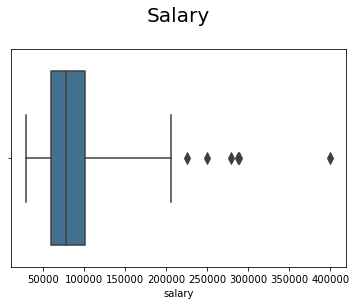

In [85]:
fig, ax = plt.subplots(figsize=(6,4))

# salary distribution can be quite skewed therefore taking whisker factor 3
sns.boxplot(x=jobs['salary'], orient='h', fliersize=8, 
            linewidth=1.5, saturation=0.5, whis=3.0, ax=ax)
ax.set_title('Salary\n', fontsize=20)
plt.show()


In [86]:
# salaries are usually spread quite skwed if high position jobs are offered as well
# therefore the factor 3 is used for the interquartil range to detect outliers
q1, q3 = np.quantile(jobs['salary'], [0.25, 0.75])
iqr = q3 - q1
outlier_upper_limit = q3 + 3*iqr
salary_outlier_idx = jobs.loc[jobs['salary'] > outlier_upper_limit].index
jobs.drop(index=salary_outlier_idx, inplace=True)
jobs.shape

(969, 6)

In [87]:
from sklearn.preprocessing import Binarizer

In [88]:
binarizer = Binarizer(threshold=median_salary)
jobs['high_salary'] = binarizer.transform(jobs[['salary']]).astype(int)
# jobs.loc[:, 'salary'] = jobs['salary'].map(lambda x: 'High' if x > median_salary else 'Low')
jobs.drop(['salary'], axis=1, inplace=True)

The chart below shows on the one hand the mean value of high or low salary per state indicated by the bars and on the other hand the number of jobs per state by the red line.

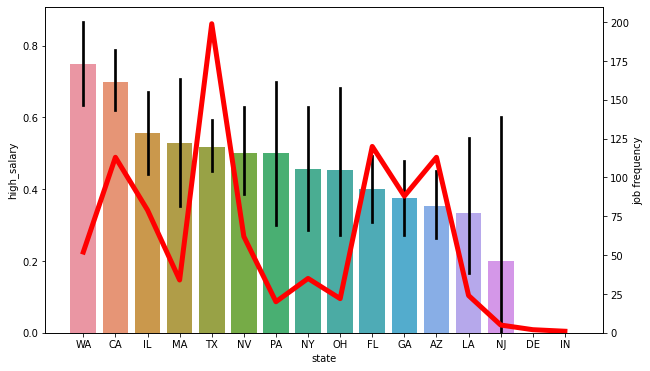

In [89]:
state_order = jobs.groupby('state').mean().sort_values(by='high_salary', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='state', y='high_salary', data=jobs, order=state_order.index, 
            errcolor='k')
plt2 = plt.twinx()
plt2.set_ylim([0, 210])
plt2.plot(jobs.groupby('state').size().reindex(state_order.index), lw=5, c='r')
plt2.set_ylabel('job frequency')
plt.show()

#### Thought experiment: What is the baseline accuracy for this model?

In [90]:
baseline_accuracy = round(jobs['high_salary'].value_counts(normalize=True).max(), 4)
baseline_accuracy

0.5046

### Create a classification model to predict High/Low salary. 


- Start by ONLY using the location as a feature.
- Use at least two different classifiers you find suitable.
- Remember that scaling your features might be necessary.
- Display the coefficients/feature importances and write a short summary of what they mean.
- Create a few new variables in your dataframe to represent interesting features of a job title (e.g. whether 'Senior' or 'Manager' is in the title).
- Incorporate other text features from the title or summary that you believe will predict the salary.
- Then build new classification models including also those features. Do they add any value?
- Tune your models by testing parameter ranges, regularization strengths, etc. Discuss how that affects your models.
- Discuss model coefficients or feature importances as applicable.

In [91]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_union, make_pipeline
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [92]:
X = jobs[['city', 'state', 'high_salary']].copy()
X = pd.get_dummies(X, prefix=['city', 'state'], columns=['city', 'state'], drop_first=True)
y = X.pop('high_salary')
X.head(1)

,city_Albany,city_Alpharetta,city_Anaheim,city_Andover,city_Arlington Heights,city_Atlanta,city_Austin,city_Avondale,city_Baldwinsville,city_Bellevue,...,state_IN,state_LA,state_MA,state_NJ,state_NV,state_NY,state_OH,state_PA,state_TX,state_WA
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [93]:
class DropDummyfierPreprocessor(BaseEstimator, TransformerMixin):
    """The transformer allows to drop and dummify columns."""
    
    def __init__(self, columns_to_drop=None, columns_to_dummify=None, prefix=None): #, drop_first=False):
        self._feature_names = []
        self.columns_to_drop = columns_to_drop
        self.columns_to_dummify = columns_to_dummify
        self.prefix = prefix
        # self.drop_first = drop_first
        self.X_new = None  
        
    def _drop_unused_cols(self, X):
        """try to drop each selected column by its own"""
        for col in self.columns_to_drop:
            try:
                X = X.drop(col, axis=1)
            except:
                pass
        return X

    def _make_dummy_cols(self, X):
        """dummify categorical features"""
        if len(self.prefix) != len(self.columns_to_dummify):
            self.prefix = None
        X = pd.get_dummies(X, columns=self.columns_to_dummify, prefix=self.prefix) #, drop_first=self.drop_first)
        return X
    
    def get_feature_names(self):
        """return feature names"""
        return self._feature_names
    
    def transform(self, X, *args):
        X = self._make_dummy_cols(X)
        # compare features which are created when the dataset is fitted (training set) with the
        # features when it is transformed (test set). Each feature that is not included in the
        # the process of fitting is discareded. Thus, in the case of fitting training data and
        # afterwards transforming the test data both possess the same features.
        if isinstance(self.X_new, pd.DataFrame):
#             cols_union = list(set(self.X_new) & set(X))  
#             cols_diff = list(set(self.X_new) - set(X))  
#             X[cols_diff] = 0  
#             X = pd.concat([X[cols_union], X[cols_diff]], axis=1)  
            cols_X = X.columns
            cols_X_new = self.X_new.columns
            cols_union = cols_X[cols_X.isin(cols_X_new)]
            X = X[cols_union]
            cols_missing = cols_X_new[~cols_X_new.isin(cols_X)]
            for col in cols_missing:
                X.insert(len(X.columns), col, 0)
            X = X[cols_X_new]

        X = self._drop_unused_cols(X)
        self._feature_names = X.columns
        return X
    
    def fit(self, X, *args):
        self.X_new = self._make_dummy_cols(X)  
        return self

In the first process only the location features are used to predict high (above median) salaries.

In [94]:
pipe = Pipeline([('prep_dum', DropDummyfierPreprocessor(columns_to_drop=['job_title', 'company', 'summary', 'high_salary'], 
                                                        columns_to_dummify=['state', 'city'], 
                                                        prefix=['state', 'city'])),
                 ('prep_scale', StandardScaler())])
X = pipe.fit_transform(jobs)
y = jobs['high_salary'].copy()


In [95]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

In [97]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [98]:
model_params = {
    'estimator': [DecisionTreeClassifier(), 
                  LogisticRegression(solver='liblinear'),
                  KNeighborsClassifier(),
                 ],
    
    'param_grid': [
        {
            'max_depth': [1, 2, 3],
            'min_samples_split': [2, 3, 4, 20,  30, 50],
            'ccp_alpha': [0, 0.001, 0.005, 0.01]
        },
        {
            'C': np.logspace(-4, 4, 15), 
            'penalty': ['l2', 'l1'],
        },
        {
            'n_neighbors': range(3, 100, 2),
            'weights': ['uniform', 'distance']
        }
    ]
}

In [99]:
import joblib
import os

In [100]:
from sklearn.model_selection import RandomizedSearchCV

In [101]:
def get_estimators_scores(X_train, y_train, X_test=None, y_test=None, 
                          models=[], params=[], verbose=1, n_jobs=2, cv=5, 
                          filenames=[], grid=True, pipeline_classifier=None):
    """
    This function fits a list of models with all possible combinations given by the
    params list either by applying grid search or randmized search and returns them. 
    The models are saved if the number of names for the filenames parameter matches 
    with the number of models. 
    
    
    Parameters:
    
    X_train (pd.DataFrame): training data frame
    y_train (pd.Series): training target values
    X_test (pd.DataFrame|default=None): test set data frame
    y_test (pd.Series|default=None): test target values
    models (list|default=[]): list of classifiers
    params (list|default=[]): list of dictionaries with parameters of each classifier for grid search or 
                              randomized search
    verbose (int|default=1): verbose parameter of the classifiers
    n_jobs (int|default=2): n_jobs parameter of the classifiers
    cv (int|cross-validation generator|default=5): cv parameter of the classifiers
    filenames (list|default=[]): a list of names to save the models, if empty then models won't be saved
    grid (boolean|default=True): True for using GridSearchCV else RandomizedSearchCV
    pipeline_classifier (str|default=None): prefix for grid search or randomized search in the parameter name 
                                            if a pipeline is used (step name of the classifier) 
                                    
    
    Returns:
    
    best_estimators (list): a list of best estimators for each model
    """
    best_estimators = []
    save_file = False
    if filenames and len(filenames) == len(models) and all(isinstance(elem, str) for elem in filenames):
        save_file = True
    
    param_obj = None
    searchCV = None
    if grid:
        searchCV = GridSearchCV
        param_obj = 'param_grid'
    else: 
        searchCV = RandomizedSearchCV
        param_obj = 'param_distributions'
        
    for i, _ in enumerate(models):
        
        if save_file and os.path.isfile(f'./models/{filenames[i]}.sav'):
            print('***********************')
            print(f'{filenames[i]}.sav exists')
            print('***********************')
            m = joblib.load(f'./models/{filenames[i]}.sav')
            best_estimators.append(m)
            continue
            
        p = {param_obj: params[i]}
        gs = searchCV(estimator=models[i], 
                          verbose = verbose,
                          n_jobs = n_jobs,
                          cv = cv,
                          **p)
        gs.fit(X_train, y_train)
        model_name = type(gs.estimator).__name__ if pipeline_classifier == None \
                                                 else type(gs.estimator.named_steps['classifier']).__name__
        print('--------------------------------------------------------')
        print('{model} - Accuracy score: {score}'.format(model=model_name,
                                                         score=gs.score(X_train, y_train).round(4)))
        print('{model} - CV training score: {score}'.format(model=model_name, 
                                                            score=gs.best_score_.round(4)))
        
        if isinstance(X_test, (pd.DataFrame, np.ndarray)) and isinstance(y_test, (pd.Series, np.ndarray)):
            print('{model} - CV test score: {score}'.format(model=model_name,
                                                            score=gs.score(X_test, y_test).round(4)))
        print('--------------------------------------------------------')
        
        best_estimators.append(gs)
        
        if save_file:
            joblib.dump(gs, f'./models/{filenames[i]}.sav')
            print('***********************')
            print(f'{filenames[i]}.sav saved')
            print('***********************')
                
    return best_estimators

In [102]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                  models = model_params['estimator'], 
                                  params = model_params['param_grid'],
                                  cv = skf,
                                  filenames = ['dtc_location_only', 
                                               'lr_location_only', 
                                               'knn_location_only'])

***********************
dtc_location_only.sav exists
***********************
***********************
lr_location_only.sav exists
***********************
***********************
knn_location_only.sav exists
***********************


In [103]:
def print_model_score(X_train, y_train, X_test=None, y_test=None, model=None, classifier_name=None):
    """Loads model and prints its results."""   
    if model:
        if classifier_name:
            model_name = model.best_estimator_.named_steps[classifier_name].__class__.__name__
        else:
            model_name = model.best_estimator_.__class__.__name__
        print('--------------------------------------------------------')
        print('{model} - Accuracy score: {score}'.format(model=model_name,
                                                             score=model.score(X_train, y_train).round(4)))
        print('{model} - CV training score: {score}'.format(model=model_name, 
                                                                score=model.best_score_.round(4)))

        if isinstance(X_test, (pd.DataFrame, np.ndarray)) and isinstance(y_test, (pd.Series, np.ndarray)):
            print('{model} - Test score: {score}'.format(model=model_name,
                                                                score=model.score(X_test, y_test).round(4)))
        print('--------------------------------------------------------')

In [104]:
model_names = ['dtc_location_only', 
               'lr_location_only', 
               'knn_location_only']
models = [joblib.load(f'./models/{m}.sav') for m in model_names]

for m in models:
    print_model_score(X_train, y_train, X_test, y_test, m)

--------------------------------------------------------
DecisionTreeClassifier - Accuracy score: 0.591
DecisionTreeClassifier - CV training score: 0.5729
DecisionTreeClassifier - Test score: 0.5773
--------------------------------------------------------
--------------------------------------------------------
LogisticRegression - Accuracy score: 0.6748
LogisticRegression - CV training score: 0.6323
LogisticRegression - Test score: 0.6082
--------------------------------------------------------
--------------------------------------------------------
KNeighborsClassifier - Accuracy score: 0.6826
KNeighborsClassifier - CV training score: 0.5884
KNeighborsClassifier - Test score: 0.5979
--------------------------------------------------------


#### DecisionTreeClassifier:
Feature Importance assigns a score to input features to show how useful they are to predict the target value. For decision trees it refers to the total reduction of the criterion to select the decision points. Because the default setting for that classifier was used, it refers to the gini score. The chart below shows that San Francisco has the highest salary income of all cities where at least 30 jobs are offered. The chart from above indicates that the state Washington has the highest salary income in total. Austin is only ranked on the third place in that chart, but therefore it has the highest job frequency. From this aspect the feature importances from the decision tree make sense, only the influence of the city Woodinville can't be explained.

In [105]:
# DecisionTreeClassifier
pd.DataFrame(list(zip(pipe.named_steps['prep_dum'].get_feature_names(), 
                      models[0].best_estimator_.feature_importances_)), 
             columns=['Feature', 'Importance']
            ).sort_values(by='Importance', ascending=False)[:5]

,Feature,Importance
141,city_San Francisco,0.464830
15,state_WA,0.263725
23,city_Austin,0.224524
164,city_Woodinville,0.046921
0,state_AZ,0.000000


In [106]:
# show mean salary income of cities which offer at least 30 jobs
# city_order = jobs.groupby('city').agg({'company': 'count'}).company > 20
# city_order

cities = jobs.groupby('city').agg({lambda x: x.count() > 30})['company']
cities_idx = cities[cities.values.ravel()].index

cities_above_30_jobs = jobs[jobs['city'].isin(cities_idx)].groupby('city')[['high_salary']] \
                           .mean().sort_values('high_salary', ascending=False)
cities_above_30_jobs.head(5)

,high_salary
city,
San Francisco,0.935484
Seattle,0.729730
Austin,0.642105
Chicago,0.615385
Los Angeles,0.585366


In [127]:
jobs[jobs['city'] == 'Woodinville']

,job_title,company,summary,city,state,high_salary
266,Industrial Maintenance Worker (Brightwater Tre...,King County,"Use vendor data and catalogs to order parts, r...",Woodinville,WA,0


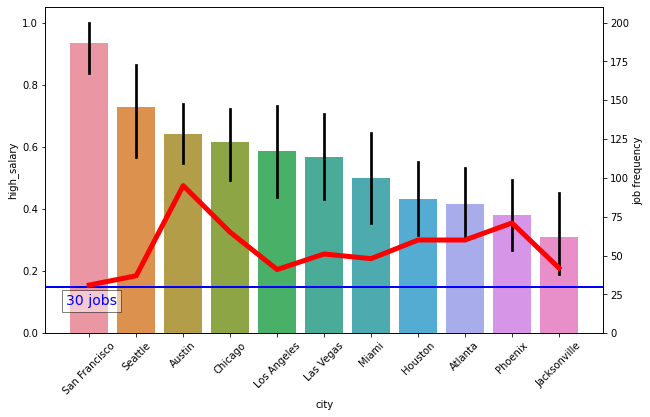

In [128]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(x='city', y='high_salary', data=jobs, order=cities_above_30_jobs.index,
            errcolor='k')
plt2 = plt.twinx()
plt2.set_ylim([0, 210])
plt2.plot(jobs.groupby('city').size().reindex(cities_above_30_jobs.index), lw=5, c='r')
plt2.set_ylabel('job frequency')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt2.axhline(y=30, xmin=0, xmax=10, lw=2, c='b', zorder=0)
plt2.text(-0.5, 18, '30 jobs', fontsize=14, c='b', bbox=dict(facecolor='white', alpha=0.5))
plt.show()

#### LogisticRegression:
- The logistc regression is using follwing link function:
$$P(y=1|X)=\frac{1}{1+e^{-z}},$$
with $z=\beta_0+\beta_{1}X_{1}+...+\beta_{n}X_{n}$ which means that a higher z value increases the probability of predicting class 1 and lower z values increase the probability to predict class 0.

The first two coefficients of the feature importance show the same behaviour as the decision tree classifier. 

In [ ]:
x = np.linspace(-2, 2, 100)
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.plot(x, np.exp(-x), c='g')
plt.axvline(0, lw=1, ls='--')
plt.axhline(1, lw=1, ls='--')
plt.title(r'function: $e^{-z}$')
plt.subplot(122)
x = np.linspace(-10, 10, 100)
y = 1/(1 + np.exp(-x))  
plt.plot(x, y, c='g')
plt.hlines(1, -10, 10, lw=1, ls='--')
plt.hlines(0.5, -10, 10, lw=1, ls='--', colors='b')
plt.hlines(0, -10, 10, lw=1, ls='--')
plt.title('sigmoid function')
plt.show()

In [ ]:
# LogisticRegression
cols = pipe.named_steps['prep_dum'].get_feature_names()
pd.DataFrame({'Feature': cols, 
              'Coefficient': models[1].best_estimator_.coef_[0], 
              'Abs_Coefficient': abs(models[1].best_estimator_.coef_[0])}
            ).sort_values(by='Abs_Coefficient', ascending=False).drop(['Abs_Coefficient'], axis=1).head(5)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [ ]:
# instead using pipeline

# X = jobs.copy()
# y = X.pop('high_salary')
# #X.reset_index(inplace=True)
# X.drop(columns=['summary'], inplace=True)
# X = pd.get_dummies(X, columns=['company', 'city', 'state'], drop_first=True)

In [ ]:
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
        
        
class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

In [ ]:
class Sparse2DenseTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, *args): #Y=None):
        return self

    def transform(self, X):
        return X.todense()

In [ ]:
from sklearn.compose import ColumnTransformer

In [ ]:
# test demonstration of StemmedCountVectorizer and StemmedTfidfVectorizer

# test_text = 'walks walked walking walker walkkt Walking'

# stem_cvec = StemmedCountVectorizer(analyzer="word", stop_words='english')

# stem_tvec = StemmedTfidfVectorizer(analyzer="word", 
#                                   stop_words='english')
#                                   #ngram_range=(1,2))


# display(pd.DataFrame(stem_cvec.fit_transform([test_text]).toarray(), 
#                      columns=stem_cvec.get_feature_names()))
# display(pd.DataFrame(stem_tvec.fit_transform([test_text]).toarray(),
#                      columns=stem_tvec.get_feature_names()))

In [ ]:
jobs.info()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
num_attrs = jobs.drop(['high_salary'], axis=1).select_dtypes(include=['int64', 'float64']).columns
cat_attrs = jobs.drop(['high_salary', 'summary', 'job_title'], axis=1).select_dtypes(include=['object']).columns
text_attr = 'job_title'

# so far no numerical features
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

text_pipeline = Pipeline([
    ('tvec', StemmedTfidfVectorizer(analyzer='word', stop_words='english', max_df=0.3, 
                                    max_features=200, ngram_range=(1,2))),
    ('dense', Sparse2DenseTransformer())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_attrs),
    ('text', text_pipeline, text_attr),
    ('cat', cat_pipeline, cat_attrs)
])

In [ ]:
X = jobs.copy()
y = X.pop('high_salary')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=1)

# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

In [ ]:
from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [ ]:
model_params = {
    'estimator': [DecisionTreeClassifier(), 
                  LogisticRegression(solver='liblinear'),
                  KNeighborsClassifier(),
                  SVC(probability=True),
                  RandomForestClassifier(),
                  AdaBoostClassifier(),  # base estimator -> decision tree
                  GradientBoostingClassifier()
                 ],
    
    'file_names': ['dtc_job_titles',
                   'lr_job_titles',
                   'knn_job_titles',
                   'svc_job_titles',
                   'rfc_job_titles',
                   'abc_job_titles',
                   'gbc_job_titles'
                  ],
    
    'param_distributions': [
        { # DecisionTreeClassifier
            'classifier__max_depth': [2, 3, 5, 8, 10],
            'classifier__max_features': ['auto', 'sqrt', 'log2'],
            'classifier__min_samples_split': [2, 4, 20, 30],
            'classifier__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.1],
            'classifier__criterion': ['gini', 'entropy']
        },
        { # LogisticRegression
            'classifier__C': np.logspace(-4, 4, 15), 
            'classifier__penalty': ['l2', 'l1'],
        },
        { # KNeighborsClassifier
            'classifier__n_neighbors': [3, 5, 7, 9, 15, 25, 45],
            'classifier__weights': ['uniform', 'distance'],
            'classifier__leaf_size': [20, 30, 40]
        },
        { # SVC
            'classifier__C': [0.025, 0.1, 0.5, 1, 100],
            'classifier__kernel': ['linear', 'poly', 'rbf']
        },
        { # RandomForestClassifier
            'classifier__n_estimators': [100, 200, 400],
            'classifier__max_depth': [2, 3, 5, 8, 10],
            'classifier__max_features': ['auto', 'sqrt', 'log2'],
            'classifier__min_samples_split': [2, 4, 20],
            'classifier__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.1],
            'classifier__criterion': ['gini', 'entropy']
        },
        { # AdaBoostClassifier
            'classifier__n_estimators': [50, 100, 200],
            'classifier__learning_rate': [0.1, 0.5, 1.]
        },
        { # GradientBoostingClassifier
            'classifier__n_estimators': [100, 200, 400],
            'classifier__min_samples_split': [2, 4, 20],
            'classifier__max_depth': [2, 3, 5, 8, 10],
            'classifier__ccp_alpha': [0, 0.001, 0.005, 0.01, 0.1],
            'classifier__learning_rate': [0.1, 0.5, 1.],
            'classifier__subsample': [0.5, 0.8, 1.]
        }    
    ]
}

model_params.update({'pipeline': [Pipeline(steps=[('preprocessor', preprocessor), ('classifier', c)]) 
                                  for c in model_params['estimator']],})

In [ ]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                   models = model_params['pipeline'], 
                                   params = model_params['param_distributions'],
                                   filenames=model_params['file_names'],
                                   cv = skf, grid=False, n_jobs=2,
                                   pipeline_classifier='classifier')

In [ ]:
models = [joblib.load(f'./models/{name}.sav') for name in model_params['file_names']]
for m in models:
    print_model_score(X_train, y_train, X_test, y_test, m, 'classifier')

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier

In [ ]:
etc = ExtraTreesClassifier(n_estimators=100)
rc = RidgeClassifier(tol=1e-2, solver="sag")
per = Perceptron(max_iter=1000, tol=1e-3)
pac = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
lsvc = LinearSVC(loss='squared_hinge', 
                 penalty='l2',
                 max_iter=100000,
                 #tol=0.01, 
                 dual=False)
sgdc = SGDClassifier(alpha=.0001,
                     penalty="elasticnet",
                     max_iter=1000,
                     tol=1e-3)


for model in [etc, rc, per, pac, lsvc, sgdc]:
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    pipe.fit(X_train, y_train)
    model_name = type(model).__name__
    print('{model} - Accuracy score: {score}' \
              .format(model=model_name,
                      score=pipe.score(X_train, y_train).round(4)))
    print('{model} - CV training score: {score}' \
              .format(model=model_name,
                      score=cross_val_score(pipe, X_train, y_train, cv=skf).mean().round(4)))
    print('{model} - CV testing score: {score}' \
              .format(model=model_name, 
                      score=cross_val_score(pipe, X_test, y_test, cv=skf).mean().round(4)))    
    print()

In [ ]:
# fine tuning of hyperparameters with gridsearch
model_params = {
    'estimators': [LinearSVC(max_iter=1000000),
                   RidgeClassifier(),
                   SVC(),
                   LogisticRegression(solver='liblinear')
                  ],
    
    'file_names': ['lin_svc_job_title',
                   'rc_job_title',
                   'svc_job_title_grid',
                   'lr_job_title_grid'
                  ],
    
    'param_grid': [
        { # LinearSVC
            'classifier__C': [0.01, 0.1, 0.5, 1., 10., 100., 1000.],
            'classifier__fit_intercept': [True, False]
        },
        { # RidgeClassifier
            'classifier__alpha': [0.01, 0.1, 0.5, 1., 10., 100., 1000.],
            'classifier__fit_intercept': [True, False],
        },
        { # SVC
            'classifier__C': np.logspace(-3, 4, 20),
            'classifier__kernel': ['linear', 'poly', 'rbf']
        },
        { # LogisticRegression
            'classifier__C': np.logspace(-4, 4, 15), 
            'classifier__penalty': ['l2', 'l1'],
        },
        
    ]
}

model_params.update({'pipeline': [Pipeline(steps=[('preprocessor', preprocessor), ('classifier', c)]) 
                                  for c in model_params['estimators']]})

In [ ]:
estimators = get_estimators_scores(X_train, y_train, X_test, y_test,
                                  models = model_params['pipeline'], 
                                  params = model_params['param_grid'],
                                  filenames=model_params['file_names'],
                                  cv = skf, n_jobs=1, pipeline_classifier='classifier')

In [ ]:
for m in estimators:
    print_model_score(X_train, y_train, X_test, y_test, model=m, classifier_name='classifier')

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# confusion matrix
def docm(y_true, y_pred, labels=None):
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0])
    if labels is not None:
        cols = ['pred_' + c for c in labels]
        df = pd.DataFrame(cm, index=labels, columns=cols)
    else:
        cols = ['pred_'+str(i) for i in range(len(cm))]
        df = pd.DataFrame(cm, columns=cols)
    return df

In [ ]:
# LinearSVC
docm(y_test, estimators[0].best_estimator_.predict(X_test), labels=['high_salary', 'low_salary'])

In [ ]:
# LogisticRegression
docm(y_test, estimators[3].best_estimator_.predict(X_test), labels=['high_salary', 'low_salary'])

### Model evaluation:

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs.


- Use cross-validation to evaluate your models.
- Evaluate the accuracy, AUC, precision and recall of the models.
- Plot the ROC and precision-recall curves for at least one of your models.

In [ ]:
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, recall_score, precision_score
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
l_svc = Pipeline(steps=[('preprocessor', preprocessor), 
                      ('classifier', LinearSVC(class_weight={0: .7, 1: .3}, random_state=42, max_iter=100000))])

params = {
    'classifier__loss': ['hinge', 'squared_hinge'],
    'classifier__C': np.logspace(-1, 3, 40),
}

model_name = 'final_model'
model = Path(f"./models/{model_name}.sav")
if not model.exists():
    gs = GridSearchCV(l_svc, 
                      scoring='precision', 
                      param_grid=params, 
                      verbose=1, 
                      n_jobs=1,
                      cv=skf)
    gs.fit(X_train, y_train)
    cc = CalibratedClassifierCV(gs.best_estimator_.named_steps['classifier'])
    clf = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('classifier', cc)])
    clf.fit(X_train, y_train)
    joblib.dump(clf, f'./models/{model_name}.sav')
    
else:
    clf = joblib.load(f'./models/{model_name}.sav')
                     
print('Precision score:', np.round(clf.score(X_train, y_train), 4))
print('CV training score:', np.round(cross_val_score(clf, X_train, y_train, cv=skf).mean(), 4))
print('Test score:', np.round(clf.score(X_test, y_test), 4))

In [ ]:
# rather to predict false negative than false positive, that's why class 0 was weighted higher 
# (and the gridsearch was layed out for f1 scoring)
fig, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True)
plot_confusion_matrix(clf, X_train, y_train, cmap='Blues', ax=ax[0], 
                      labels=[1,0], values_format='.0f') #, normalize='all')
plot_confusion_matrix(clf, X_test, y_test, cmap='Blues', ax=ax[1],
                      labels=[1,0], values_format='.0f') #, normalize='all')
ax[0].set_title('Training set\n', fontsize=20)
ax[1].set_title('Test set\n', fontsize=20)

for a in ax:
    texts = a.texts
    for text in texts:
        text.set_size(20)

plt.show()

In [ ]:
def predict_at_threshold(x, threshold=0.5):
    if x >= threshold:
        return 1
    else:
        return 0

In [ ]:
# Increase the threshold for the probability of class 1 to have a higher precision on prediction of class 0
predictions_train = clf.predict(X_train)
predictions_test = clf.predict(X_test)

Y_prediction = pd.DataFrame(clf.predict_proba(X_test), columns=['low_salary', 'high_salary'])
Y_prediction['predict_with_thres'] = Y_prediction['high_salary'].apply(predict_at_threshold, threshold=0.6)
Y_prediction['true_value'] = y_test.values

In [ ]:
print('Training accuracy:', accuracy_score(y_train, predictions_train).round(4))
print('Testing accuracy:', accuracy_score(y_test, predictions_test).round(4))
print('-----------------------------')
print('Training precision:', precision_score(y_train, predictions_train).round(4))
print('Testing precision:', precision_score(y_test, predictions_test).round(4))
print('-----------------------------')
print('Testing precision with threshold:', precision_score(y_test, Y_prediction['predict_with_thres']).round(4))

In [ ]:
docm(y_test, Y_prediction['predict_with_thres'], ['high_salary', 'low_salary'])

In the ROC curve you want to gain a really strong slope in the beginning with as less false positive rate as possible. The best score would be having a area under the curve of 1 to have a perfect prediction. 

In [ ]:
from sklearn.metrics import roc_auc_score, average_precision_score, plot_roc_curve, plot_precision_recall_curve
import scikitplot as skplt
from matplotlib.colors import ListedColormap

In [ ]:
plt.style.use('seaborn')
cmap = ListedColormap(sns.color_palette("husl", 3))
probs_train = clf.predict_proba(X_train)
probs_test = clf.predict_proba(X_test)

fig, ax = plt.subplots(1, 2, figsize=(16,6))
skplt.metrics.plot_roc(y_train, probs_train, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=14, cmap=cmap, ax=ax[0])
skplt.metrics.plot_roc(y_test, probs_test, plot_micro=True, plot_macro=True, 
                       title_fontsize=20, text_fontsize=14, cmap=cmap, ax=ax[1])
ax[0].set_title('ROC Curves (training set)', fontsize=18)
ax[1].set_title('ROC Curves (test set)', fontsize=18)

for axis in ax:
    axis.set_xlim([-0.03, 1.03])
    axis.set_ylim([-0.03, 1.03])
    axis.legend(fontsize=14)
plt.show()

The precision shows the ratio of how often the positive labelled class was predicted correclty over 
all predictions which were done for that class. Whereas the recall depicts the ratio of that class over it occurence
in the dataset. That means that you can predict less, but more precise to have a high precision score, but then chance
increases that the class occurence more often then you actually predict it and then the recall decreases.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(16,6))
skplt.metrics.plot_precision_recall(y_train, probs_train, plot_micro=True, 
                                    cmap=cmap, ax=ax[0], text_fontsize=14)

skplt.metrics.plot_precision_recall(y_test, probs_test, plot_micro=True, 
                                    cmap=cmap, ax=ax[1], text_fontsize=14)

ax[0].set_title('Precision-Recall Curve (training set)', fontsize=18)
ax[1].set_title('Precision-Recall Curve (test set)', fontsize=18)
for axis in ax:
    axis.set_xlim([-0.03, 1.03])
    axis.set_ylim([-0.03, 1.03])
    axis.legend(fontsize=14)
    axis.set_xlabel('Recall', fontsize=14)
    axis.set_ylabel('Precision', fontsize=14)
plt.show()

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### Bonus:

- Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions. 
- Discuss the differences and explain when you want a high-recall or a high-precision model in this scenario.
- Obtain the ROC/precision-recall curves for the different models you studied (at least the tuned model of each category) and compare.

In [ ]:
## YOUR CODE HERE

### Summarize your results in an executive summary written for a non-technical audience.
   
- Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

In [ ]:
## YOUR TEXT HERE IN MARKDOWN FORMAT 

<img src="http://imgur.com/xDpSobf.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

### BONUS

Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

In [ ]:
## YOUR LINK HERE IN MARKDOWN FORMAT 